In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch
from torch.nn import functional as F
import spacy


plt.style.use('ggplot')

In [11]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(torch.cuda.is_available())

nlp = spacy.load("en_core_web_sm")

True


In [13]:
df = pd.read_csv('2024-06-29.csv')
df.head()

,Unnamed: 0,comment,timestamp
0,0,"\nAs a reminder, this subreddit [is for civil ...",2024-06-29 13:39:30
1,1,Chaos feels like the goal at this point. This ...,2024-06-29 14:35:04
2,2,In the same week they legalized bribery and ga...,2024-06-29 15:48:41
3,3,It’s a rogue court dismantling government inst...,2024-06-29 13:54:23
4,4,My message to the double haters is this. Don't...,2024-06-29 14:03:38


In [15]:
df = df.rename(columns={'Unnamed: 0': 'id'})
df.head()

,id,comment,timestamp
0,0,"\nAs a reminder, this subreddit [is for civil ...",2024-06-29 13:39:30
1,1,Chaos feels like the goal at this point. This ...,2024-06-29 14:35:04
2,2,In the same week they legalized bribery and ga...,2024-06-29 15:48:41
3,3,It’s a rogue court dismantling government inst...,2024-06-29 13:54:23
4,4,My message to the double haters is this. Don't...,2024-06-29 14:03:38


In [59]:
# Named Entity Recognition
data = {
    'comment': [],
    'entities': []
}

for index, row in df.iterrows():
    text = row['comment']
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    if entities:
        data['comment'].append(text)
        data['entities'].append(entities)

output_df = pd.DataFrame(data)
output_df = pd.concat([df, output_df['entities']], axis=1)

In [63]:
# Get polarity scores for each comment
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    encoded_text = {key: value.to(device) for key, value in encoded_text.items()}
    output = model(**encoded_text)
    
    scores = output[0][0].detach().cpu().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [65]:
# Iterate comments through polarity_scores_roberta
res = {}
for i, row in df.iterrows():
    try:
        text = str(row['comment'])
        id = row['id']
        berta = polarity_scores_roberta(text)
        res[id] = berta
    except RuntimeError:
        print(f'Runtime Error: id index {id}')

Runtime Error: id index 101
Runtime Error: id index 966
Runtime Error: id index 1205
Runtime Error: id index 2117
Runtime Error: id index 2574
Runtime Error: id index 2586
Runtime Error: id index 2663
Runtime Error: id index 4407
Runtime Error: id index 4726
Runtime Error: id index 4837
Runtime Error: id index 4981
Runtime Error: id index 5172
Runtime Error: id index 5198
Runtime Error: id index 6743
Runtime Error: id index 7525
Runtime Error: id index 7526
Runtime Error: id index 7635
Runtime Error: id index 7661
Runtime Error: id index 7967
Runtime Error: id index 8113
Runtime Error: id index 8862
Runtime Error: id index 10219
Runtime Error: id index 10870
Runtime Error: id index 11035
Runtime Error: id index 11346
Runtime Error: id index 11418
Runtime Error: id index 11458
Runtime Error: id index 11762
Runtime Error: id index 12657
Runtime Error: id index 12818
Runtime Error: id index 13126
Runtime Error: id index 14734
Runtime Error: id index 14969
Runtime Error: id index 14975
Run

In [73]:
results = pd.DataFrame(res).T
results = results.reset_index().rename(columns={'index': 'id'})
results = results.merge(output_df, how='left')

In [75]:
results.head()

,id,roberta_neg,roberta_neu,roberta_pos,comment,timestamp,entities
0,0,0.340939,0.568925,0.090137,"\nAs a reminder, this subreddit [is for civil ...",2024-06-29 13:39:30,"[(here](https://www.reddit.com, ORG)]"
1,1,0.644755,0.323912,0.031334,Chaos feels like the goal at this point. This ...,2024-06-29 14:35:04,"[(decades, DATE), (Donda Academy, ORG), (the B..."
2,2,0.182935,0.343331,0.473734,In the same week they legalized bribery and ga...,2024-06-29 15:48:41,"[(the same week, DATE)]"
3,3,0.723544,0.260741,0.015714,It’s a rogue court dismantling government inst...,2024-06-29 13:54:23,"[(FDA, ORG)]"
4,4,0.693620,0.286474,0.019906,My message to the double haters is this. Don't...,2024-06-29 14:03:38,"[(Trump, ORG), (decades, DATE)]"


In [98]:
filtered = results.dropna()

def biden_sentiment(entities):
    return all(entity == ('Biden', 'PERSON') for entity in entities)

def trump_sentiment(entities):
    return all(entity == ('Trump', 'PERSON') for entity in entities)
    
biden = filtered[filtered['entities'].apply(biden_sentiment)]
trump = filtered[filtered['entities'].apply(trump_sentiment)]

In [79]:
labels = ['Negative', 'Neutral', 'Positive']
values = [neg, neu, pos]

In [77]:
neg = results['roberta_neg'].mean(axis=0)
neu = results['roberta_neu'].mean(axis=0)
pos = results['roberta_pos'].mean(axis=0)

In [106]:
b_neg = biden['roberta_neg'].mean(axis=0)
b_neu = biden['roberta_neu'].mean(axis=0)
b_pos = biden['roberta_pos'].mean(axis=0)

t_neg = trump['roberta_neg'].mean(axis=0)
t_neu = trump['roberta_neu'].mean(axis=0)
t_pos = trump['roberta_pos'].mean(axis=0)

In [108]:
labels = ['Joe Biden', 'Donald Trump']
neg_values = [b_neg, t_neg]
neu_values = [b_neu, t_neu]
pos_values = [b_pos, t_pos]

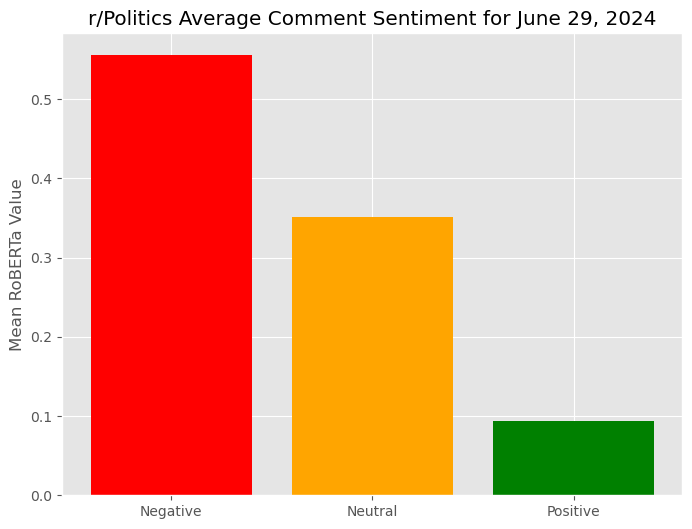

In [81]:
plt.figure(figsize=(8,6))
plt.bar(labels, values, color=['red', 'orange', 'green'])

plt.title('r/Politics Average Comment Sentiment for June 29, 2024')
plt.ylabel('Mean RoBERTa Value')
plt.show()

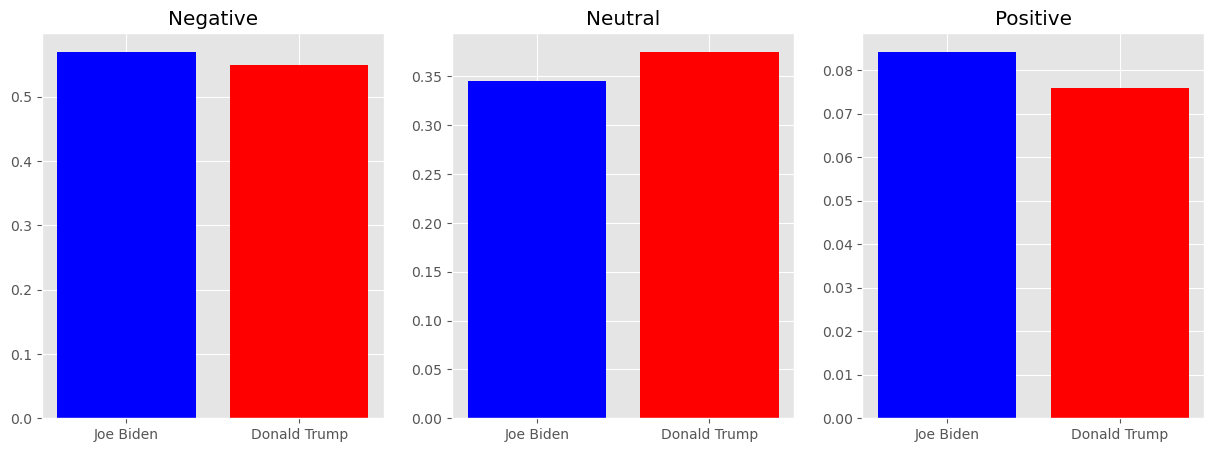

In [120]:
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].bar(labels, neg_values, color=['blue', 'red'])
axs[1].bar(labels, neu_values, color=['blue', 'red'])
axs[2].bar(labels, pos_values, color=['blue', 'red'])

axs[0].set_title('Negative')
axs[1].set_title('Neutral')
axs[2].set_title('Positive')

plt.show()